# Programmable illumination: phase contrast

_Srayan Gangopadhyay_  
_Thu 9 Mar 2023_

Sources:
- https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle
- https://stackoverflow.com/questions/38674027/find-the-row-indexes-of-several-values-in-a-numpy-array

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from led_posns import *

To do:
- Combine all images into single stack
- Rescale all images
- Find centre LED using max brightness
- Find rotation using max brightness

- did we acquire enough images total?

## Simulating the LED setup to get the required indices

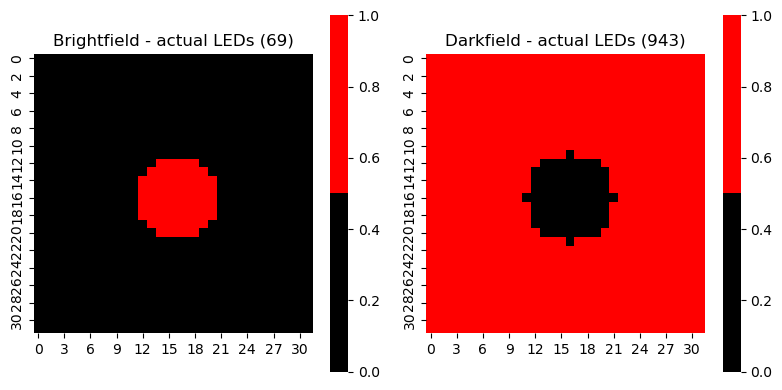

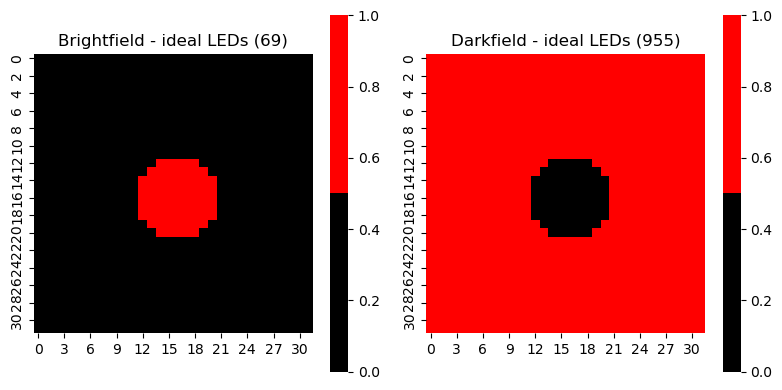

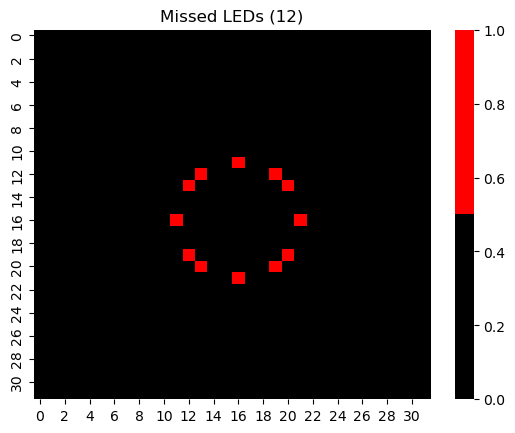

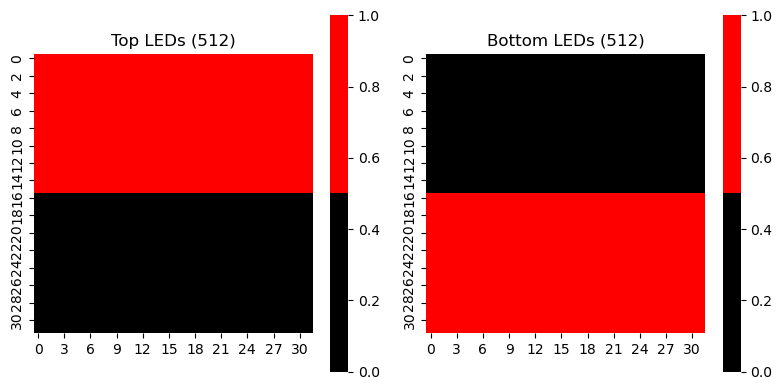

ValueError: too many values to unpack (expected 2)

In [2]:
bright_posns, dark_posns, top_posns, bottom_posns, left_posns, right_posns = get_led_posns(32, 5)

## Reading in the images

In [ ]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 bead phantom raster'
brightfield = io.imread(img_dir + r'\2023-03-08 bead phantom brightfield raster kept stack.tif')[:-1]
darkfield_1 = io.imread(img_dir + r'\2023-03-08 bead phantom darkfield raster.tiff')
darkfield_2 = io.imread(img_dir + r'\2023-03-08 bead phantom darkfield raster_X1.tif')
darkfield = np.concatenate((darkfield_1, darkfield_2))[:-1]


# note: rescale for exposure time?
print(f'Loaded {brightfield.shape[0]} bright and {darkfield.shape[0]} dark images.')

In [ ]:
# # background subtraction
# bright_bg = np.mean(io.imread(r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 brightfield 50ms\MMStack_Pos0.ome.tif'), axis=0)
# dark_bg = np.mean(io.imread(r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 darkfield 200ms\MMStack_Pos0.ome.tif'), axis=0)
# brightfield = np.clip(brightfield - bright_bg, 0, brightfield.max())
# darkfield = np.clip(darkfield - dark_bg, 0, darkfield.max())

Background subtraction appears to break things. Skipping for now. 

## Calculating the phase contrast images

Assuming $I_{DPC} = \frac{I_L - I_R}{I_L + I_R}$ (from [here](https://doi.org/10.1371/journal.pone.0124938))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(np.sum(np.concatenate((brightfield, darkfield)), axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Full illumination')
mpbl = axs[1].imshow(np.sum(brightfield, axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Brightfield')
mpbl = axs[2].imshow(np.sum(darkfield, axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Darkfield')
plt.show()

In [ ]:
top = np.sum(np.concatenate((brightfield[XinY(top_posns, bright_posns)], darkfield[XinY(top_posns, dark_posns)])), axis=0)
bottom = np.sum(np.concatenate((brightfield[XinY(bottom_posns, bright_posns)], darkfield[XinY(bottom_posns, dark_posns)])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(top, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Top illumination')
mpbl = axs[1].imshow(bottom, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Bottom illumination')
mpbl = axs[2].imshow((top-bottom)/(top+bottom), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Top-bottom DPC')
plt.show()

In [ ]:
left = np.sum(np.concatenate((brightfield[XinY(left_posns, bright_posns)], darkfield[XinY(left_posns, dark_posns)])), axis=0)
right = np.sum(np.concatenate((brightfield[XinY(right_posns, bright_posns)], darkfield[XinY(right_posns, dark_posns)])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(left, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Left illumination')
mpbl = axs[1].imshow(right, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Right illumination')
mpbl = axs[2].imshow((left-right)/(left+right), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Left-right DPC')
plt.show()

## Can we find the central LED from the images?

In [ ]:
brightfield.shape

In [ ]:
bright_brightnesses = [np.mean(im) for im in brightfield]
dark_brightnesses = [np.mean(im) for im in darkfield]

In [ ]:
plt.plot(bright_brightnesses)

In [ ]:
plt.plot(dark_brightnesses)

In [ ]:
leds = np.zeros((32, 32))
for i in range(len(bright_posns)):
    coord = bright_posns[i]
    leds[coord[0], coord[1]] = np.mean(brightfield[i])
for i in range(len(dark_posns)):
    coord = dark_posns[i]
    leds[coord[0], coord[1]] = np.mean(darkfield[i])

In [ ]:
plt.matshow(leds)
plt.plot(16, 16, 'o', label='central LED')
plt.plot(15.5, 15.5, )
plt.axhline(y=16)
plt.axvline(x=16)
plt.colorbar()

## Digital refocusing

$I^{\Delta Z} = \Sigma I_i(x + \Delta z \tan{\theta_x}, y + \Delta z \tan{\theta_y})$, where $\tan{\theta_x} = \frac{\Delta x}{L} = \frac{(16-i) \times 4 mm}{L}$ and $\tan{\theta_y} = \frac{(j-16) \times 4 mm}{L}$, if we define x upwards and y to the right of the central LED (since (0,0) is top-left). 

TODO: measure L  
NOTE: effect of water on k-vector?

In [ ]:
import cv2


def shift_image(image, x_shift_mm, y_shift_mm):
    """
    Return translated image, given x and y shifts in mm,
    assuming a pixel size of 6.45um
    """
    x_shift_px = x_shift_mm / 6.45e-3
    y_shift_px = y_shift_mm / 6.45e-3
    
    M = np.float32([
        [1, 0, x_shift_px],
        [0, 1, y_shift_px]
    ])
    
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


def required_shifts(i, j, delta_z, L):
    """
    Calculated required shifts in mm given LED coordinates
    and required refocus distance delta_z, assuming a 32x32
    LED array with pitch 4mm, with LED (16, 16) centred on 
    the optical axis, and with (0, 0) at the top left.
    """
    delta_x = (16-i) * 4
    tan_theta_x = delta_x / L
    x_shift_mm = delta_z * tan_theta_x
    
    delta_y = (j-16) * 4
    tan_theta_y = delta_y / L
    y_shift_mm = delta_y * tan_theta_y
    
    
    return x_shift_mm, y_shift_mm